In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, KFold
from sklearn.pipeline import Pipeline
from DataExtract import *
from ContestParticipants import *

## Import Dataset

In [16]:
# feature values
features = ['PLAYER_ID', 'PLAYER_NAME', 'TEAM_ABBREVIATION', 'GP', 'W_PCT', 
            'MIN', 'FG3M', 'FG3A', 'FG3_PCT', 'PTS', 'PLUS_MINUS', 'NBA_FANTASY_PTS']

# feature values (Rank ver.) 
features_rank = ['PLAYER_ID', 'PLAYER_NAME', 'TEAM_ABBREVIATION', 'GP_RANK',
                 'W_PCT_RANK', 'MIN_RANK', 'FG3M_RANK', 'FG3A_RANK', 'FG3_PCT_RANK', 
                 'PTS_RANK', 'PLUS_MINUS_RANK', 'NBA_FANTASY_PTS_RANK']

# Import data set between 2010-11 and 2022-23
df = DataExtract(features, 2010)
df_rank = DataExtract(features_rank, 2010)

# Import the 3point Contest participants table
participants = ContestParticipants()

ReadTimeout: HTTPSConnectionPool(host='stats.nba.com', port=443): Read timed out. (read timeout=100)

## 1. Total/per-game stats data

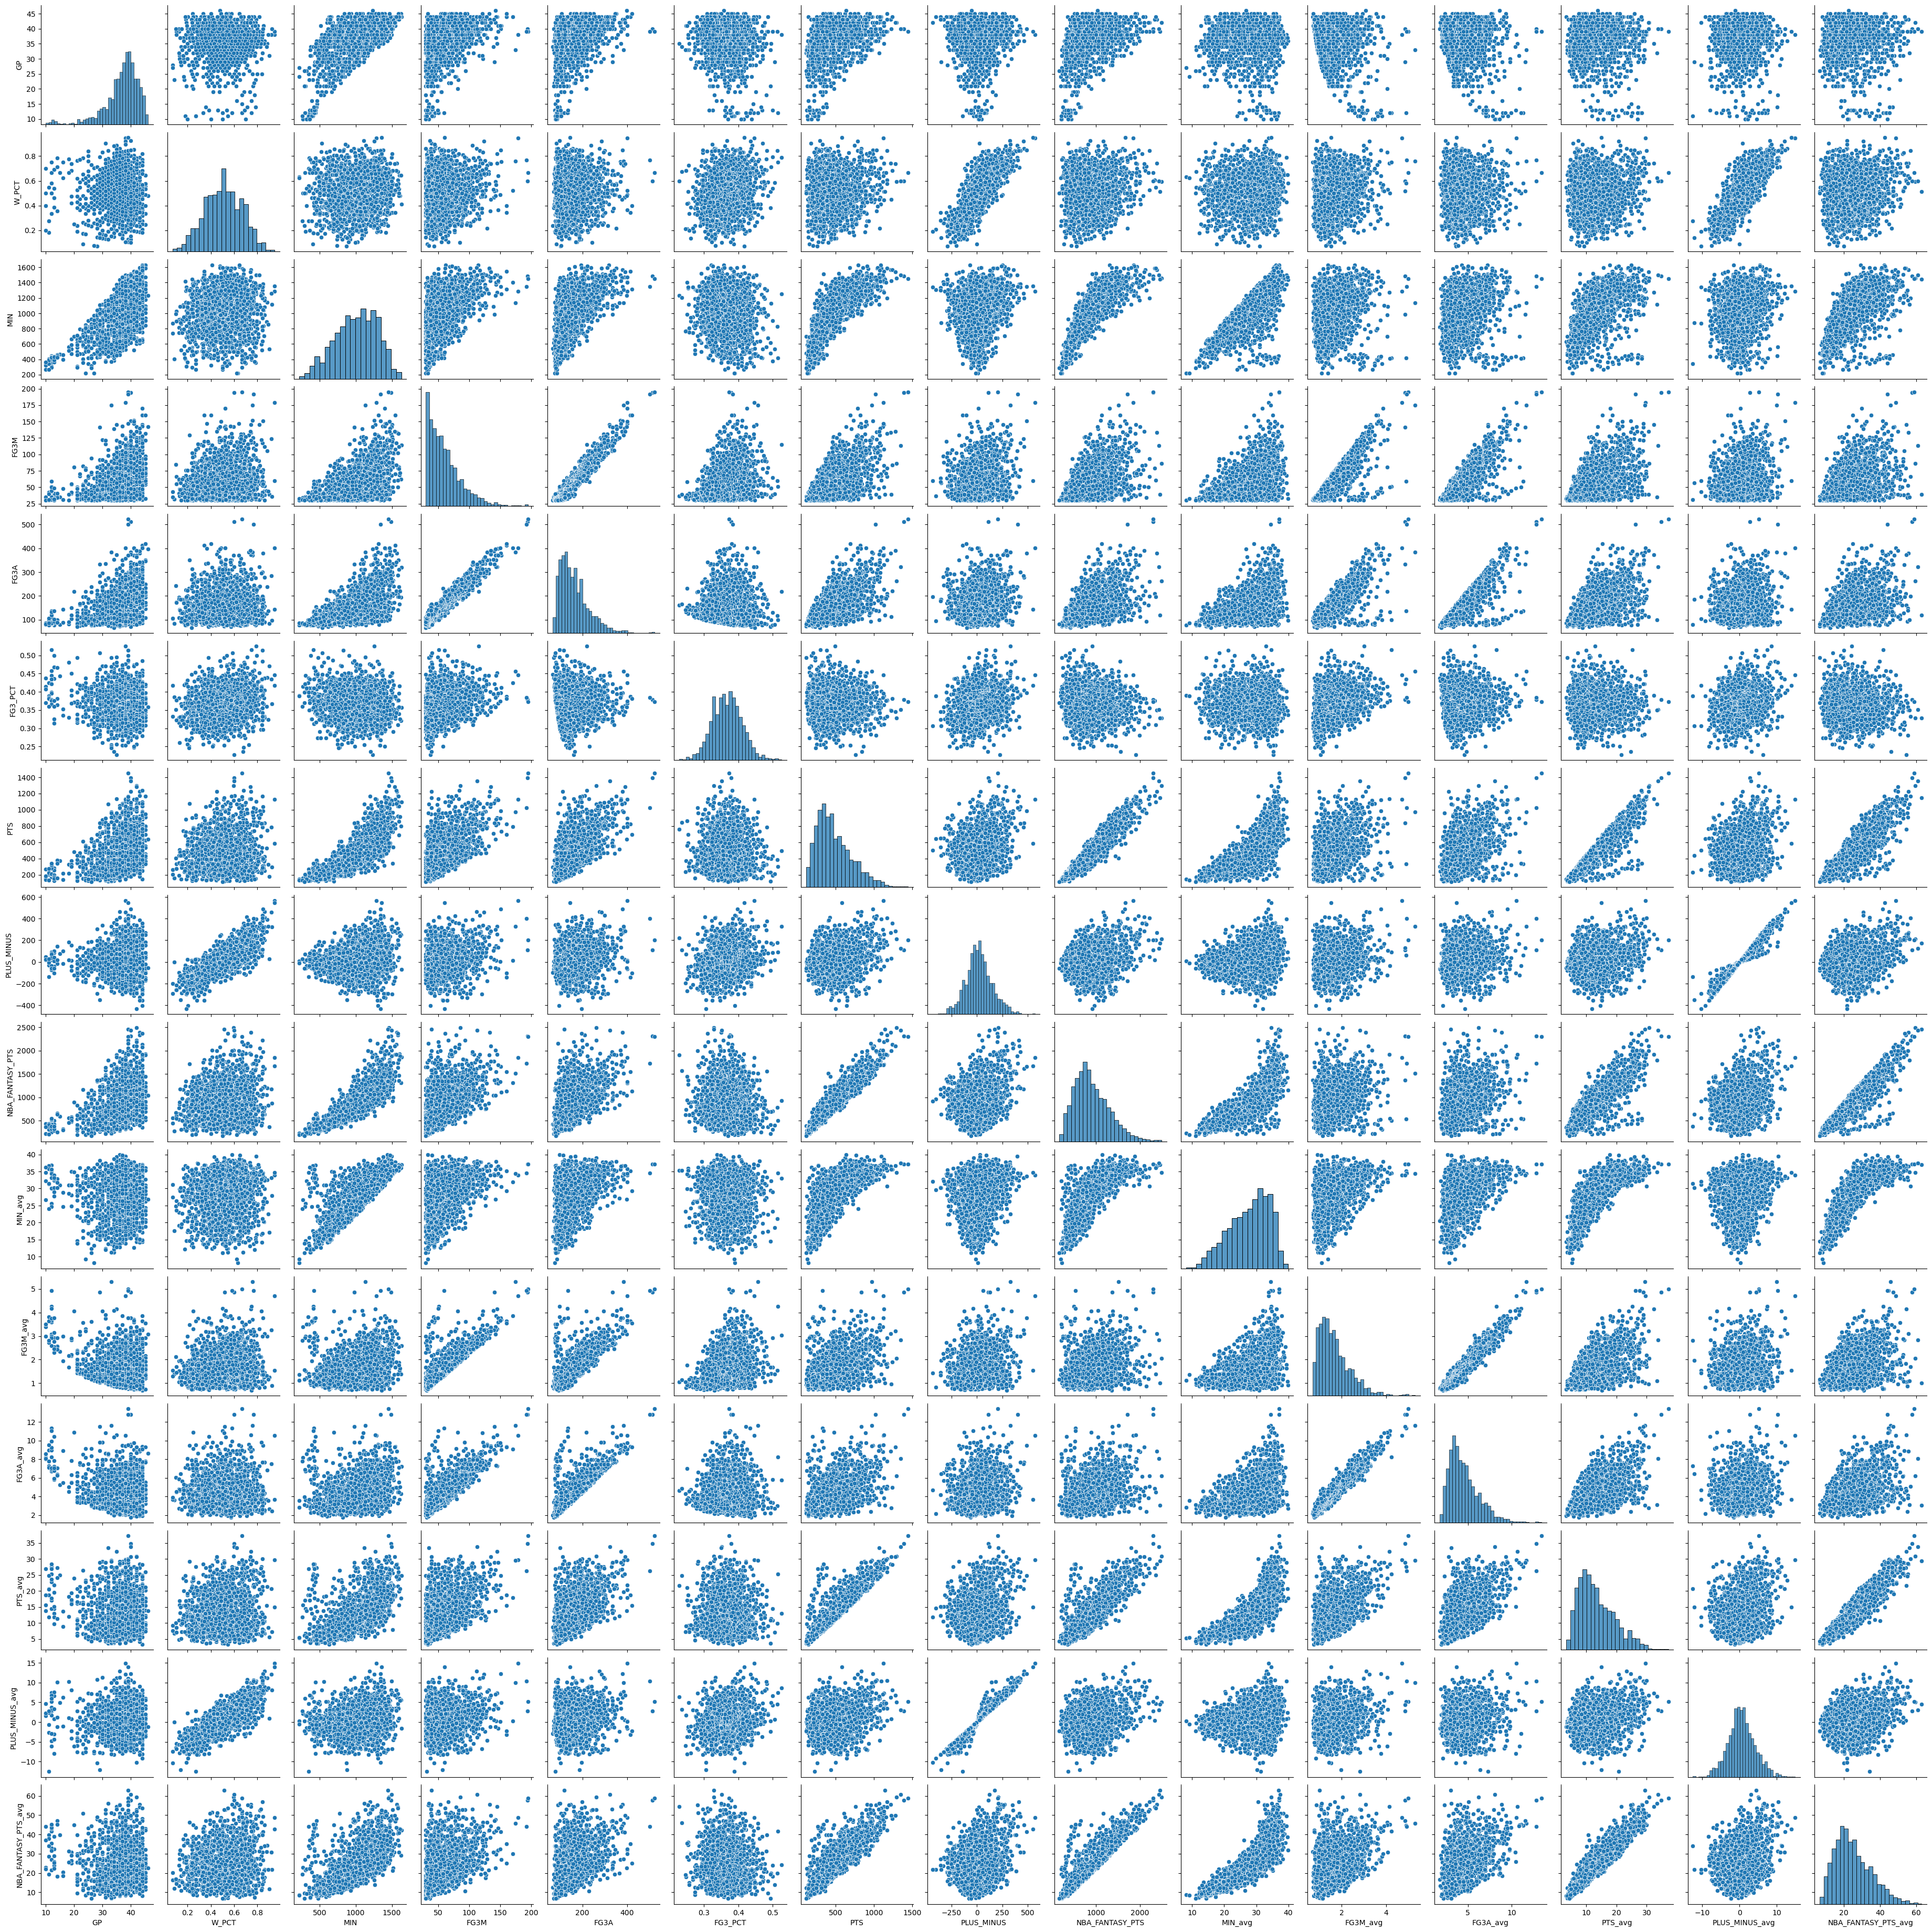

In [ ]:
# Variables used in the model
var_for_X = ['GP', 'W_PCT', 'MIN', 'FG3M', 'FG3A', 'FG3_PCT', 'PTS', 'PLUS_MINUS', 'NBA_FANTASY_PTS', 
             'MIN_avg', 'FG3M_avg', 'FG3A_avg', 'PTS_avg', 'PLUS_MINUS_avg', 'NBA_FANTASY_PTS_avg']

# Create columns which are the average stats per game in 'df' table
columns = ['MIN', 'FG3M', 'FG3A', 'PTS', 'PLUS_MINUS', 'NBA_FANTASY_PTS']
columns_avg = list(map(lambda s: s + '_avg', columns))
df[columns_avg] = df[columns].div(df['GP'], axis=0)

# Concatenate the target variable (participant)
data = pd.merge(df, participants, on=['Season', 'PLAYER_ID'], how='left')
data['Participant'].where(data['Participant'].notna(), 0, inplace=True)

'''
Though Dirk Nowitzki participated in the contest in 2018-19, 
his FG3M is less than 15 and so I don't include the data.
(keep the condition as FG3M>=30)
'''

# Simple exploratory Analysis : scatter plots for each pair of feature variables
sns.pairplot(data[var_for_X])

Thease plots show that some pairs of variables are correlated. For example, FG3M and FG3A appear to have strong positive corration, which corresponds to our intuitions that more attempts of 3pt shots cause more shots made, since I limited the dataset to only players who made >=30 3pt shots, or are good shooters.

I remove redundant variables to prevent the model from multicollinearity. Specifically, I leave 'FG3M', 'FG3_PCT', 'MIN_avg', 'FG3M_avg', 'PLUS_MINUS_avg', 'NBA_FANTASY_PTS_avg', where 'NBA_FANTASY_PTS' is an indicator of players' performance which reflects various stats like points, rebounds and assists. I added the 'NBA_FANTASY_PTS_avg' as a metrics for "star" degree.

scaledLR: 0.976105 (0.017836)
scaledKNN: 0.976105 (0.017836)
scaledDT: 0.953919 (0.020965)
scaledSVC: 0.976105 (0.017836)


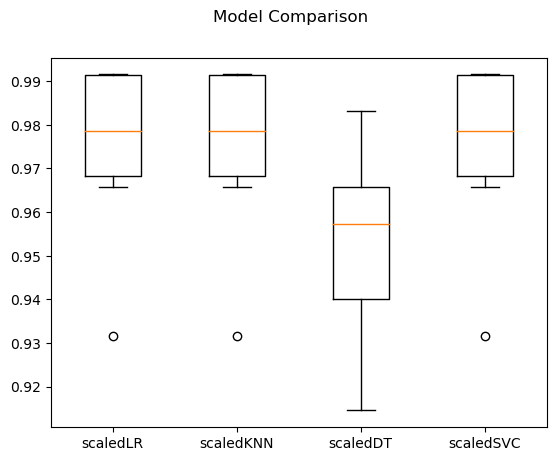

In [ ]:
# Update the X variable columns
var_for_X = ['FG3M', 'FG3_PCT', 'MIN_avg', 'FG3M_avg', 'PLUS_MINUS_avg', 'NBA_FANTASY_PTS_avg']

# Divide this dataset into data for ML and data for application
X, y = data.loc[data['Season']!='2022-23',var_for_X], data.loc[data['Season']!='2022-23','Participant']
X_app = data.loc[data['Season']=='2022-23',var_for_X]

# Divide dataset for ML into train and test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

pipes = []

# Use min-max scaler since some varibles are skewed
pipes.append(('scaledLR' , (Pipeline([('scaled' , MinMaxScaler()),('LR' ,LogisticRegression())]))))
pipes.append(('scaledKNN' , (Pipeline([('scaled' , MinMaxScaler()),('KNN' ,KNeighborsClassifier())]))))
pipes.append(('scaledDT' , (Pipeline([('scaled' , MinMaxScaler()),('DT' ,DecisionTreeClassifier())]))))
pipes.append(('scaledSVC' , (Pipeline([('scaled' , MinMaxScaler()),('SVC' ,SVC())]))))

results = []
model_name = []
for pipe ,model in pipes:
    kfold = KFold(n_splits=10)
    cv_results = cross_val_score(model , X_train ,y_train ,cv=kfold , scoring='accuracy')
    results.append(cv_results)
    model_name.append(pipe)
    msg = "%s: %f (%f)" % (pipe, cv_results.mean(), cv_results.std())
    print(msg)

# Compare the results of different Models
fig = plt.figure()
fig.suptitle('Model Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(model_name)
plt.show()

#pipe.fit(X_train, y_train)
#gs_results = pipe.named_steps['gridsearchcv']
#print('Best Score: %.3f' % gs_results.best_score_)
#print('Best alpha: %s' % gs_results.best_params_)
#print('Test Score: %.3f' % pipe.score(X_test, y_test))
#print('Coefficients: \n', pd.DataFrame(gs_results.best_estimator_.coef_))
#print('Intercept: %.3f' % gs_results.best_estimator_.intercept_)

# Apply this model to this year's data 
#pred_prob = pipe.predict_proba(X_app)[:,1]

# The output of the prediction (in the descending order of predicted probability)
#df_2022 = data[data['Season']=='2022-23']
#df_2022['Pred_Prob'] = pred_prob

#df_2022 = df_2022.sort_values('Pred_Prob', ascending=False).reset_index(drop=True)
#print('Likely Candidates:')
#df_2022.head(10)


## 2. Rank data

In [ ]:
# Variables used in the model
var_for_X_rank = ['GP_RANK', 'W_PCT_RANK', 'MIN_RANK', 'FG3M_RANK', 'FG3A_RANK', 'FG3_PCT_RANK', 
                  'PTS_RANK', 'PLUS_MINUS_RANK', 'NBA_FANTASY_PTS_RANK']

# Concatenate the target variable (participant)
data_rank = pd.merge(df_rank, participants, on=['Season', 'PLAYER_ID'], how='left')
data_rank['Participant'].where(data_rank['Participant'].notna(), 0, inplace=True)

'''
Though Dirk Nowitzki participated in the contest in 2018-19, 
his FG3M is less than 15 and so I don't include the data.
(keep the condition as FG3M>=30)
'''

# Simple exploratory Analysis : scatter plots for each pair of feature variables
sns.pairplot(data_rank[var_for_X_rank])

'2010-11'